# Models
All models are run on the test set i.e. a subset of the original data set. This is done on 200 different test sets and results are presented as average performance. 

The models included in this script are:
- Random model - choosing and ranking candidates randomly from the test set
- Mergesort model - choosing and ranking candidates from the test set based on best grades in high school
- Gendersort - Mergesort w. gender accountability - choosing and ranking candidates based on high school grades with account equal gender representation (alternating between females and males in the ranking)
- Plain Xgboost regression model
- Reduced Xgboost regression model without sensitive attributes 
- Xgboost regression model account for diversity 


## Load packages

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
import numpy as np
import random 
from sklearn.utils import shuffle

## Plots setup

In [2]:
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (10,5)
    mpl.rcParams["figure.dpi"] = 400
setup_mpl()

## Load dataset

In [3]:
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv("NEW_X_test_y_test.csv") 
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
df_for_random = df.copy()

## Mergesort ranker

In [18]:
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv('dfs_test199 copy 3.csv')
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
dfs_test  = df_new.copy()

dfs_test_use = np.array_split(dfs_test, 200)

In [19]:
X_test_y_test_FULL = pd.DataFrame()
dfs_test_use_temp=dfs_test_use.copy()

for i in range(200):
    dfs_test_use_temp[i]= dfs_test_use_temp[i].sort_values(by="3", ascending=False, kind="mergesort")
    dfs_test_use_temp[i]= dfs_test_use_temp[i].reset_index()

    data_value_counts_gen = []
    
    for j in range(1,len(dfs_test_use_temp[i])+1):
        data_value_counts_gen.append(np.array([dfs_test_use_temp[i]["4"][:j].value_counts(normalize=True)]))
    dfs_test_use_temp[i]["value_counts_col_GENDER"] = data_value_counts_gen

    data_entropy = []
    for k in range(len(dfs_test_use_temp[i])):
        data_entropy.append(-(dfs_test_use_temp[i]["value_counts_col_GENDER"][k]*np.log2(dfs_test_use_temp[i]["value_counts_col_GENDER"][k])).sum())
   
  
    dfs_test_use_temp[i]["entropy_col_GENDER"] = data_entropy

    X_test_y_test_FULL = X_test_y_test_FULL.append(dfs_test_use_temp[i])


X_test_y_test_FULL.index.names = ['INDEXES']


df_sort_BIG =X_test_y_test_FULL

In [20]:
#Mean gender entropy
df_sort_BIG_mean =  df_sort_BIG.groupby('INDEXES').mean()
#df_sort_BIG_mean["intr_col_entropy"] = df_sort_BIG_mean['entropy_col_GENDER'].expanding().mean()


#CMA std entropy
df_sort_BIG_std =  df_sort_BIG.groupby('INDEXES').std()/np.sqrt(200)
#df_sort_BIG_std["incr_col_entropy"] = df_sort_BIG_std['entropy_col_GENDER'].expanding().mean()


#Adding standard error column for "incr_col_mean" and variables for plotting 200.
df_sort_BIG_mean["incr_half_std"] = 0.5*df_sort_BIG_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_sort_BIG_mean["lower_std"] = df_sort_BIG_mean["entropy_col_GENDER"] - df_sort_BIG_mean["incr_half_std"]
df_sort_BIG_mean["upper_std"] = df_sort_BIG_mean["entropy_col_GENDER"] + df_sort_BIG_mean["incr_half_std"]


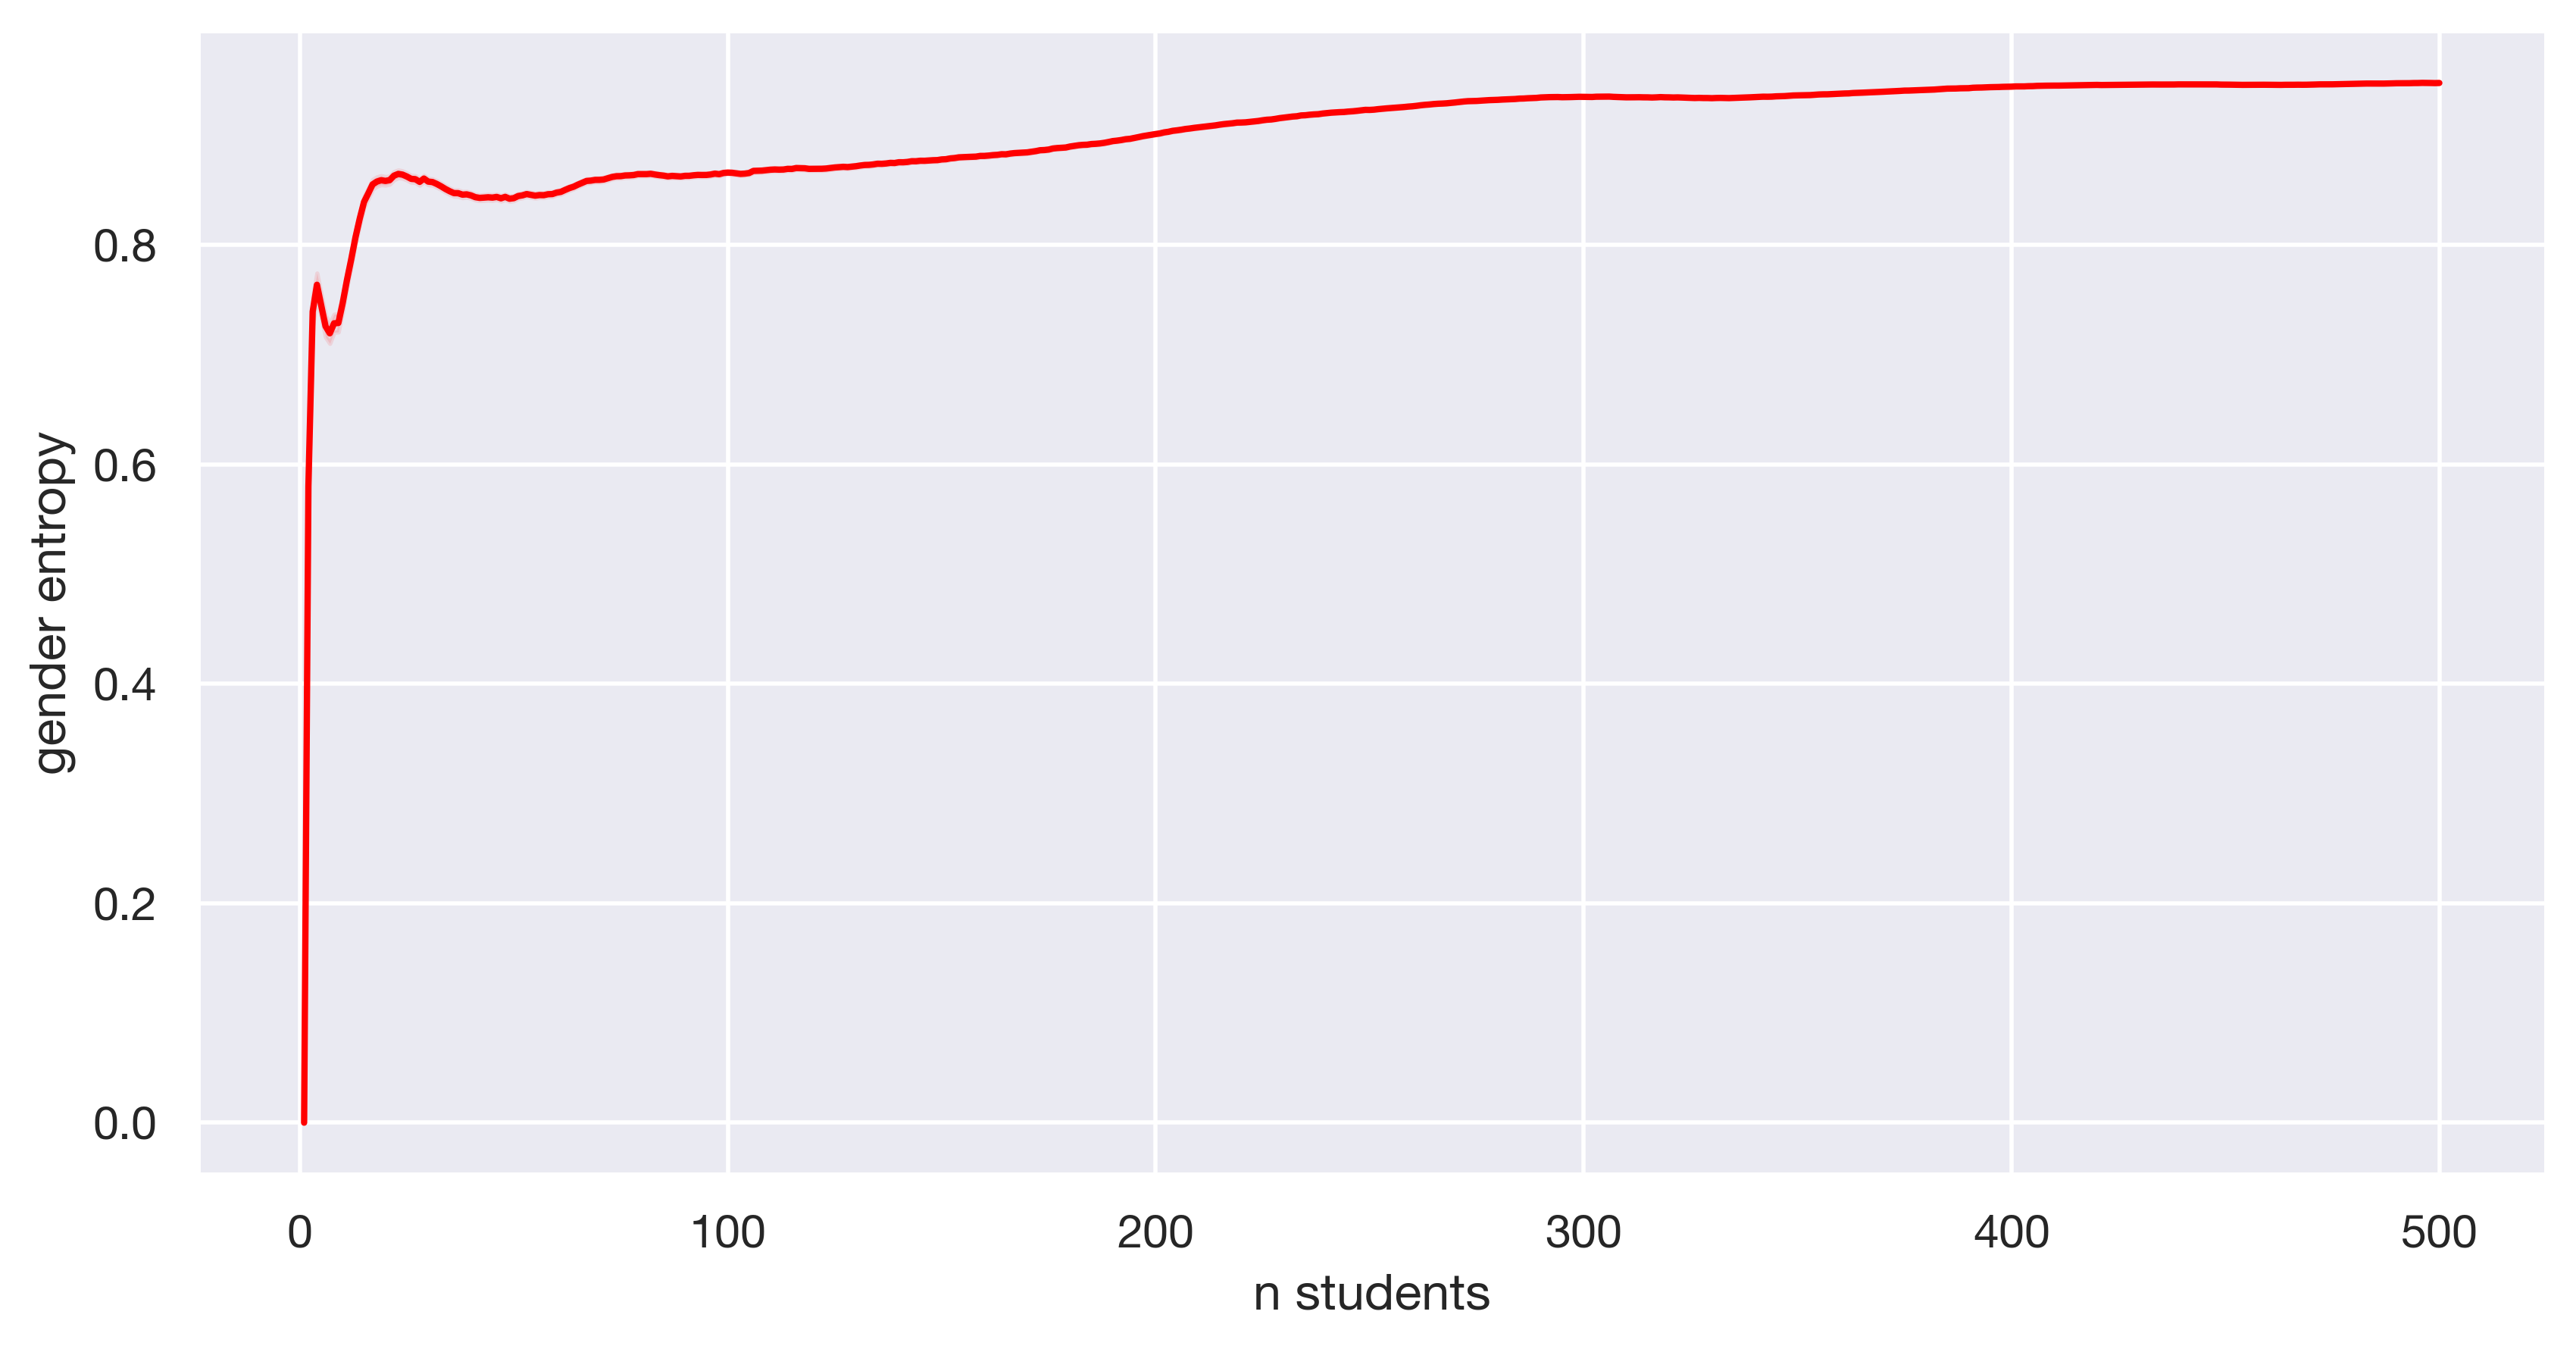

In [21]:
#n students 
df_sort_BIG_mean["n_students"] = range(1,len(df_sort_BIG_mean)+1)

sns.lineplot(data=df_sort_BIG_mean[0:500], x="n_students", y="entropy_col_GENDER",  color="red", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG_mean[0:500], alpha=0.1, color="red")
plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.show()

## Gendersort ranker

In [ ]:
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv('dfs_test199 copy 3.csv')
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
dfs_test  = df_new.copy()

dfs_test_use = np.array_split(dfs_test, 200)

X_test_y_test_GENDER = pd.DataFrame()


 
def gender_mergesort_BIG(df):
    
    dfs_test_use = df 
 
    X_test_y_test_GENDER = pd.DataFrame()
 
    for i in range(len(dfs_test_use)):
        sorted_with_gender = pd.DataFrame()
        FEMALES = pd.DataFrame()
        MALES = pd.DataFrame()
        fem = dfs_test_use[i][dfs_test_use[i]['4'] != 0] #'4' = Gender_bins
        mal = dfs_test_use[i][dfs_test_use[i]['4'] != 1]

        fem = fem.sort_values(by="3", ascending=False, kind="mergesort").reset_index() #'3' = HI_AVG_GPA
        mal = mal.sort_values(by="3", ascending=False, kind="mergesort").reset_index()

        FEMALES = FEMALES.append(fem)
        MALES=MALES.append(mal)
        
        
        FEMALES.index.names = ['INDEXES']
        MALES.index.names = ['INDEXES']

        if FEMALES['3'].max() > MALES['3'].max():
            sorted_with_gender = pd.concat([FEMALES,MALES], sort=False).sort_index()
        else: 
            sorted_with_gender = pd.concat([MALES,FEMALES], sort=False).sort_index()
        

        data_value_counts_gen = []

        for k in range(1,len(sorted_with_gender)+1):
            data_value_counts_gen.append(np.array([sorted_with_gender["4"][:k].value_counts(normalize=True)]))
        sorted_with_gender["value_counts_col_GENDER"] = data_value_counts_gen

        data_entropy = []
        for l in range(len(sorted_with_gender)):
            data_entropy.append(-(sorted_with_gender["value_counts_col_GENDER"].iloc[l]*np.log2(sorted_with_gender["value_counts_col_GENDER"].iloc[l])).sum())
        sorted_with_gender["entropy_col_GENDER"] = data_entropy
        
        #append each i df to big df
        X_test_y_test_GENDER = X_test_y_test_GENDER.append(sorted_with_gender)
     
        
    return X_test_y_test_GENDER.reset_index()
        

In [ ]:
gender_df_BIG = gender_mergesort_BIG(dfs_test_use)


In [ ]:
#CMA gender entropy
gender_df_BIG_mean =  gender_df_BIG.groupby('INDEXES').mean()


#SMA std entropy
gender_df_BIG_std =  gender_df_BIG.groupby('INDEXES').std()/np.sqrt(200)

#Adding standard error column for "incr_col_mean" and variables for plotting 200.
gender_df_BIG_mean["incr_half_std"] = 0.5*gender_df_BIG_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
gender_df_BIG_mean["lower_std"] = gender_df_BIG_mean["entropy_col_GENDER"] - gender_df_BIG_mean["incr_half_std"]
gender_df_BIG_mean["upper_std"] = gender_df_BIG_mean["entropy_col_GENDER"] + gender_df_BIG_mean["incr_half_std"]


#nstudents
gender_df_BIG_mean["n_students"] = range(1,len(gender_df_BIG_mean)+1)


In [ ]:
## PLOT

#sns.lineplot(data=gender_df_BIG_mean[0:500], x="INDEXES", y="incr_col_GENDER",  color="red", ci="sd")
# sns.lineplot(data=gender_df_BIG_mean[0:500], x="INDEXES", y="incr_col_GENDER",  color="red", ci="sd")

# big gender df
#sns.lineplot(data=gender_df_BIG_mean[0:500], x="INDEXES", y="entropy_col_GENDER",  color="blue", ci="sd", linewidth=0.1)
sns.lineplot(data=gender_df_BIG_mean[0:500], x="n_students", y="entropy_col_GENDER",  color="blue", ci="sd", linewidth=0.5)
plt.fill_between("n_students", "lower_std", "upper_std",data=gender_df_BIG_mean[0:500], alpha=0.1, color="blue")
plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.show()

## Plain XGBoost 

In [ ]:
df_PLAIN_TWO_NY = pd.read_csv('TWO_samlet_preds_index_ny_PLAIN.csv')
indexs = np.arange(0,500)
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY.loc[df_PLAIN_TWO_NY['Unnamed: 0'].isin(indexs)]
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.reset_index()
#apply new column of cumsum+1

#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_PLAIN_TWO_NY_use["Unnamed: 0"].unique():
    stds.append(df_PLAIN_TWO_NY_use[df_PLAIN_TWO_NY_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY.loc[df_PLAIN_TWO_NY['Unnamed: 0'].isin(indexs)]

In [ ]:
df_PLAIN_TWO_NY_use["Gender_bins"][2]
GUDF = pd.read_csv('GUDF.csv')

Splitte_PLAIN = np.array_split(df_PLAIN_TWO_NY_use, 200)
GUDF['Idx'] = GUDF['Unnamed: 0'] 


In [ ]:
pd.options.mode.chained_assignment = None 
#value counts for each df in all dfs
PLAIN_USE_VALUE_COUNTS = pd.DataFrame(columns=['value_counts_col_GENDER'])
i = 0
while i < 200: #iterate over 200 dfs
    idx = 0
    while idx <= Splitte_PLAIN[i]["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        #append each value to column in empty dataframe
        PLAIN_USE_VALUE_COUNTS = PLAIN_USE_VALUE_COUNTS.append({'value_counts_col_GENDER' : np.array([Splitte_PLAIN[i]["Gender_bins"][:idx].value_counts(normalize=True)])}, ignore_index=True)     
        idx = idx+1 
    i = i+1


In [ ]:
# PLAIN_USE_VALUE_COUNTS.iloc[[500,510, 1000,1010]]

In [ ]:
#append value counts to dataframe
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.reset_index()

In [ ]:
df_PLAIN_TWO_NY_use["value_counts_col_GENDER"] = PLAIN_USE_VALUE_COUNTS.value_counts_col_GENDER
# df_PLAIN_TWO_NY_use

In [ ]:
#get entropy of valuecounts for all rows
df_PLAIN_TWO_NY_entropy_GENDER = []
for i in range(len(df_PLAIN_TWO_NY_use)):
    df_PLAIN_TWO_NY_entropy_GENDER.append(-(df_PLAIN_TWO_NY_use["value_counts_col_GENDER"][i]*np.log2(df_PLAIN_TWO_NY_use["value_counts_col_GENDER"][i])).sum())    

df_PLAIN_TWO_NY_use["entropy_col_GENDER"] = df_PLAIN_TWO_NY_entropy_GENDER

In [ ]:
#create entropy mean df and entropy std df
df_PLAIN_TWO_NY_ENTROPY = df_PLAIN_TWO_NY_use
df_PLAIN_TWO_NY_ENTROPY_std = df_PLAIN_TWO_NY_ENTROPY.groupby('Unnamed: 0').std()/np.sqrt(200)
df_PLAIN_TWO_NY_ENTROPY_mean =  df_PLAIN_TWO_NY_ENTROPY.groupby('Unnamed: 0').mean()


### CMA entropy mean and CMA standard error

In [ ]:
#df_PLAIN_TWO_NY_ENTROPY_mean["CMA_gender_entropy"] = df_PLAIN_TWO_NY_ENTROPY_mean.entropy_col_GENDER.expanding().mean()

#df_PLAIN_TWO_NY_ENTROPY_std["CMA_gender_entropy"] = df_PLAIN_TWO_NY_ENTROPY_std.entropy_col_GENDER.expanding().mean()/np.sqrt(200)

df_PLAIN_TWO_NY_ENTROPY_mean["n_students"] = range(1,len(df_PLAIN_TWO_NY_ENTROPY_mean)+1)

# df_PLAIN_TWO_NY_ENTROPY_std[50:150]


df_PLAIN_TWO_NY_ENTROPY_mean["incr_half_std"] = .5*df_PLAIN_TWO_NY_ENTROPY_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_PLAIN_TWO_NY_ENTROPY_mean["lower_std"] = df_PLAIN_TWO_NY_ENTROPY_mean["entropy_col_GENDER"] - df_PLAIN_TWO_NY_ENTROPY_mean["incr_half_std"]
df_PLAIN_TWO_NY_ENTROPY_mean["upper_std"] = df_PLAIN_TWO_NY_ENTROPY_mean["entropy_col_GENDER"] + df_PLAIN_TWO_NY_ENTROPY_mean["incr_half_std"]


In [ ]:
## MEAN Entropy
entr_plain = df_PLAIN_TWO_NY_ENTROPY_mean["entropy_col_GENDER"][499]
print("entr_plain: ", entr_plain)

In [ ]:
#sns.lineplot(data=df_PLAIN_TWO_NY_ENTROPY_mean[:500], x="Unnamed: 0", y="entropy_col_GENDER",  color="blue", ci="sd", linewidth=0.5)
sns.lineplot(data=df_PLAIN_TWO_NY_ENTROPY_mean[:500], x="n_students", y="entropy_col_GENDER",  color="blue", ci="sd", linewidth=0.5)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_PLAIN_TWO_NY_ENTROPY_mean[:500], alpha=0.1, color="blue")
plt.xlabel('n students')
plt.ylabel('gender entropy')

## Reduced XGBoost

In [ ]:
df_wo = pd.read_csv('TWO_samlet_preds_index_ny_WO.csv')
#only take n students from index 1-500
indexs = np.arange(0,500)
#df_plain["n_students"] = range(len(df_plain))
df_wo_use = df_wo.loc[df_wo['Unnamed: 0'].isin(indexs)]
df_wo_use = df_wo_use.reset_index()
#apply new column of cumsum+1


#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_wo_use["Unnamed: 0"].unique():
    stds.append(df_wo_use[df_wo_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_wo_use = df_wo.loc[df_wo['Unnamed: 0'].isin(indexs)]

#split df
Splitte_PLAIN = np.array_split(df_wo_use, 200) 


In [ ]:
pd.options.mode.chained_assignment = None 
# df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.iloc[:5000]


#value counts for each df in all dfs
PLAIN_USE_VALUE_COUNTS = pd.DataFrame(columns=['value_counts_col_GENDER'])
i = 0
while i < 200: #iterate over 200 dfs
    idx = 0
    while idx <= Splitte_PLAIN[i]["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        #append each value to column in empty dataframe
        PLAIN_USE_VALUE_COUNTS = PLAIN_USE_VALUE_COUNTS.append({'value_counts_col_GENDER' : np.array([Splitte_PLAIN[i]["Gender_bins"][:idx].value_counts(normalize=True)])}, ignore_index=True)     
        idx = idx+1 
    i = i+1


In [ ]:
#append value counts to dataframe
df_wo_use = df_wo_use.reset_index()

df_wo_use["value_counts_col_GENDER"] = PLAIN_USE_VALUE_COUNTS.value_counts_col_GENDER


In [ ]:
#get entropy of valuecounts for all rows
df_wo_entropy_GENDER = []
for i in range(len(df_PLAIN_TWO_NY_use)):
    df_wo_entropy_GENDER.append(-(df_wo_use["value_counts_col_GENDER"][i]*np.log2(df_wo_use["value_counts_col_GENDER"][i])).sum())    

df_wo_use["entropy_col_GENDER"] = df_wo_entropy_GENDER

#create entropy mean df and entropy std df
df_wo_ENTROPY = df_wo_use
df_wo_ENTROPY_std = df_wo_ENTROPY.groupby('Unnamed: 0').std()/np.sqrt(200)
df_wo_ENTROPY_mean =  df_wo_ENTROPY.groupby('Unnamed: 0').mean()


In [ ]:
#expand means of df_wo_ENTROPY_mean and df_wo_ENTROPY_std
#df_wo_ENTROPY_mean["CMA_gender_entropy"] = df_wo_ENTROPY_mean.entropy_col_GENDER.expanding().mean()

#df_wo_ENTROPY_std["CMA_gender_entropy"] = df_wo_ENTROPY_std.entropy_col_GENDER.expanding().mean()/np.sqrt(200)

df_wo_ENTROPY_mean["n_students"] = range(1,len(df_wo_ENTROPY_mean)+1)


#create std error
df_wo_ENTROPY_mean["incr_half_std"] = .5*df_wo_ENTROPY_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_wo_ENTROPY_mean["lower_std"] = df_wo_ENTROPY_mean["entropy_col_GENDER"] - df_wo_ENTROPY_mean["incr_half_std"]
df_wo_ENTROPY_mean["upper_std"] = df_wo_ENTROPY_mean["entropy_col_GENDER"] + df_wo_ENTROPY_mean["incr_half_std"]




In [ ]:
## MEAN Entropy
entr_wo = df_wo_ENTROPY_mean["entropy_col_GENDER"][499]
print("entr_wo: ", entr_wo)

In [ ]:

#df_WO_ENTROPY = df_wo_use
#df_WO_ENTROPY_std = df_WO_ENTROPY.groupby('Unnamed: 0').std()
#df_WO_ENTROPY_mean =  df_WO_ENTROPY.groupby('Unnamed: 0').mean()
# df_WO_ENTROPY_mean = df_WO_ENTROPY_mean.sort_values(by=['Preds'], ascending=False)
#df_WO_ENTROPY_mean["ENTROPY_KAT"] = df_WO_ENTROPY_mean.entropy_col_GENDER.expanding().mean()
# sns.lineplot(data=df_WO_ENTROPY_mean, x="Unnamed: 0", y="ENTROPY_KAT",  color="red", ci="sd")


In [ ]:
sns.lineplot(data=df_wo_ENTROPY_mean[:500], x="n_students", y="entropy_col_GENDER",  color="orange", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_wo_ENTROPY_mean[:500], alpha=0.1, color="orange")
plt.xlabel('n students')
plt.ylabel('gender entropy')

## Fairness enhanced Ranker 

In [7]:
df_FAIR_TWO_NY = pd.read_csv('re_ranked_199_NY.csv')
indexs = np.arange(0,500)
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY.loc[df_FAIR_TWO_NY['Unnamed: 0'].isin(indexs)]
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY_use.reset_index()
#apply new column of cumsum+1


#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_FAIR_TWO_NY_use["Unnamed: 0"].unique():
    stds.append(df_FAIR_TWO_NY_use[df_FAIR_TWO_NY_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY_use.loc[df_FAIR_TWO_NY_use['Unnamed: 0'].isin(indexs)]


#split df
Splitte_PLAIN = np.array_split(df_FAIR_TWO_NY_use, 200)


In [8]:
## Create entropy

pd.options.mode.chained_assignment = None 


#value counts for each df in all dfs
PLAIN_USE_VALUE_COUNTS = pd.DataFrame(columns=['value_counts_col_GENDER'])
i = 0
while i < 200: #iterate over 200 dfs
    idx = 0
    while idx <= Splitte_PLAIN[i]["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        #append each value to column in empty dataframe
        PLAIN_USE_VALUE_COUNTS = PLAIN_USE_VALUE_COUNTS.append({'value_counts_col_GENDER' : np.array([Splitte_PLAIN[i]["Gender_bins"][:idx].value_counts(normalize=True)])}, ignore_index=True)     
        idx = idx+1 
    i = i+1


#append value counts to dataframe
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY_use.reset_index()

df_FAIR_TWO_NY_use["value_counts_col_GENDER"] = PLAIN_USE_VALUE_COUNTS.value_counts_col_GENDER


#get entropy of valuecounts for all rows
df_fair_entropy_GENDER = []
for i in range(len(df_FAIR_TWO_NY_use)):
    df_fair_entropy_GENDER.append(-(df_FAIR_TWO_NY_use["value_counts_col_GENDER"][i]*np.log2(df_FAIR_TWO_NY_use["value_counts_col_GENDER"][i])).sum())    

df_FAIR_TWO_NY_use["entropy_col_GENDER"] = df_fair_entropy_GENDER

#create entropy mean df and entropy std df
df_fair_ENTROPY = df_FAIR_TWO_NY_use
df_fair_ENTROPY_std = df_fair_ENTROPY.groupby('Unnamed: 0').std()/np.sqrt(200)
df_fair_ENTROPY_mean =  df_fair_ENTROPY.groupby('Unnamed: 0').mean()


#expand means of df_wo_ENTROPY_mean and df_wo_ENTROPY_std
df_fair_ENTROPY_mean["CMA_gender_entropy"] = df_fair_ENTROPY_mean.entropy_col_GENDER.expanding().mean()

#df_fair_ENTROPY_std["CMA_gender_entropy"] = df_fair_ENTROPY_std.entropy_col_GENDER.expanding().mean()

df_fair_ENTROPY_mean["n_students"] = range(1,len(df_fair_ENTROPY_mean)+1)


#create std error to plot
df_fair_ENTROPY_mean["incr_half_std"] = .5*df_fair_ENTROPY_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_fair_ENTROPY_mean["lower_std"] = df_fair_ENTROPY_mean["entropy_col_GENDER"] - df_fair_ENTROPY_mean["incr_half_std"]
df_fair_ENTROPY_mean["upper_std"] = df_fair_ENTROPY_mean["entropy_col_GENDER"] + df_fair_ENTROPY_mean["incr_half_std"]


In [ ]:
# SE for cum: 
df_fair_ENTROPY_std["CMA_gender_entropy"] = df_fair_ENTROPY_std.entropy_col_GENDER.expanding().mean()

#create std error to plot
df_fair_ENTROPY_mean["incr_half_std"] = .5*df_fair_ENTROPY_std["CMA_gender_entropy"] #0.5 of std to plot on both sides of mean
df_fair_ENTROPY_mean["lower_std_cum"] = df_fair_ENTROPY_mean["CMA_gender_entropy"] - df_fair_ENTROPY_mean["incr_half_std"]
df_fair_ENTROPY_mean["upper_std_cum"] = df_fair_ENTROPY_mean["CMA_gender_entropy"] + df_fair_ENTROPY_mean["incr_half_std"]


In [ ]:
## MEAN Entropy
entr_fair = df_fair_ENTROPY_mean["entropy_col_GENDER"][499]
print("entr_fair: ", entr_fair)

In [ ]:
sns.lineplot(data=df_fair_ENTROPY_mean[:500], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd", linewidth=0.1)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[:500], alpha=0.1, color="green")
plt.xlabel('n students')
plt.ylabel('gender entropy')


### FAIR entropy: mean and CMA

In [ ]:
#k=0
#l=500


#sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd")
#plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="green")

#sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="CMA_gender_entropy",  color="lightgreen", ci="sd")
#plt.fill_between("n_students", "lower_std_cum", "upper_std_cum",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="lightgreen")

#plt.xlabel('n students')
#plt.ylabel('gender entropy')
#plt.legend(["Fairness enhanced XGBoost", "CMA Fairness enhanced XGBoost"], loc ="lower right")
#plt.show()

## FAIR Mergesort

In [23]:
df_merge_fair_load = pd.read_csv("200_Merge_fair.csv")

## Fairness enhanced MERGESORT 

df_merge_fair = df_merge_fair_load.copy()
#indexs = np.arange(0,500)
#df_FAIR_TWO_NY_use = df_FAIR_TWO_NY.loc[df_FAIR_TWO_NY['Unnamed: 0'].isin(indexs)]
#df_FAIR_TWO_NY_use = df_FAIR_TWO_NY_use.reset_index()
#apply new column of cumsum+1


#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_merge_fair["Unnamed: 0"].unique():
    stds.append(df_merge_fair[df_merge_fair["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_merge_fair = df_merge_fair.loc[df_merge_fair['Unnamed: 0'].isin(indexs2)]


#split df
Splitte_PLAIN = np.array_split(df_merge_fair, 200)


## Create entropy

pd.options.mode.chained_assignment = None 


#value counts for each df in all dfs
PLAIN_USE_VALUE_COUNTS = pd.DataFrame(columns=['value_counts_col_GENDER'])
i = 0
while i < 200: #iterate over 200 dfs
    idx = 0
    while idx <= Splitte_PLAIN[i]["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        #append each value to column in empty dataframe
        PLAIN_USE_VALUE_COUNTS = PLAIN_USE_VALUE_COUNTS.append({'value_counts_col_GENDER' : np.array([Splitte_PLAIN[i]["Gender_bins"][:idx].value_counts(normalize=True)])}, ignore_index=True)     
        idx = idx+1 
    i = i+1


#append value counts to dataframe
df_merge_fair = df_merge_fair.reset_index()

df_merge_fair["value_counts_col_GENDER"] = PLAIN_USE_VALUE_COUNTS.value_counts_col_GENDER



In [24]:


#get entropy of valuecounts for all rows
df_fair_entropy_GENDER = []
for i in range(len(df_merge_fair)):
    df_fair_entropy_GENDER.append(-(df_merge_fair["value_counts_col_GENDER"][i]*np.log2(df_merge_fair["value_counts_col_GENDER"][i])).sum())    

df_merge_fair["entropy_col_GENDER"] = df_fair_entropy_GENDER



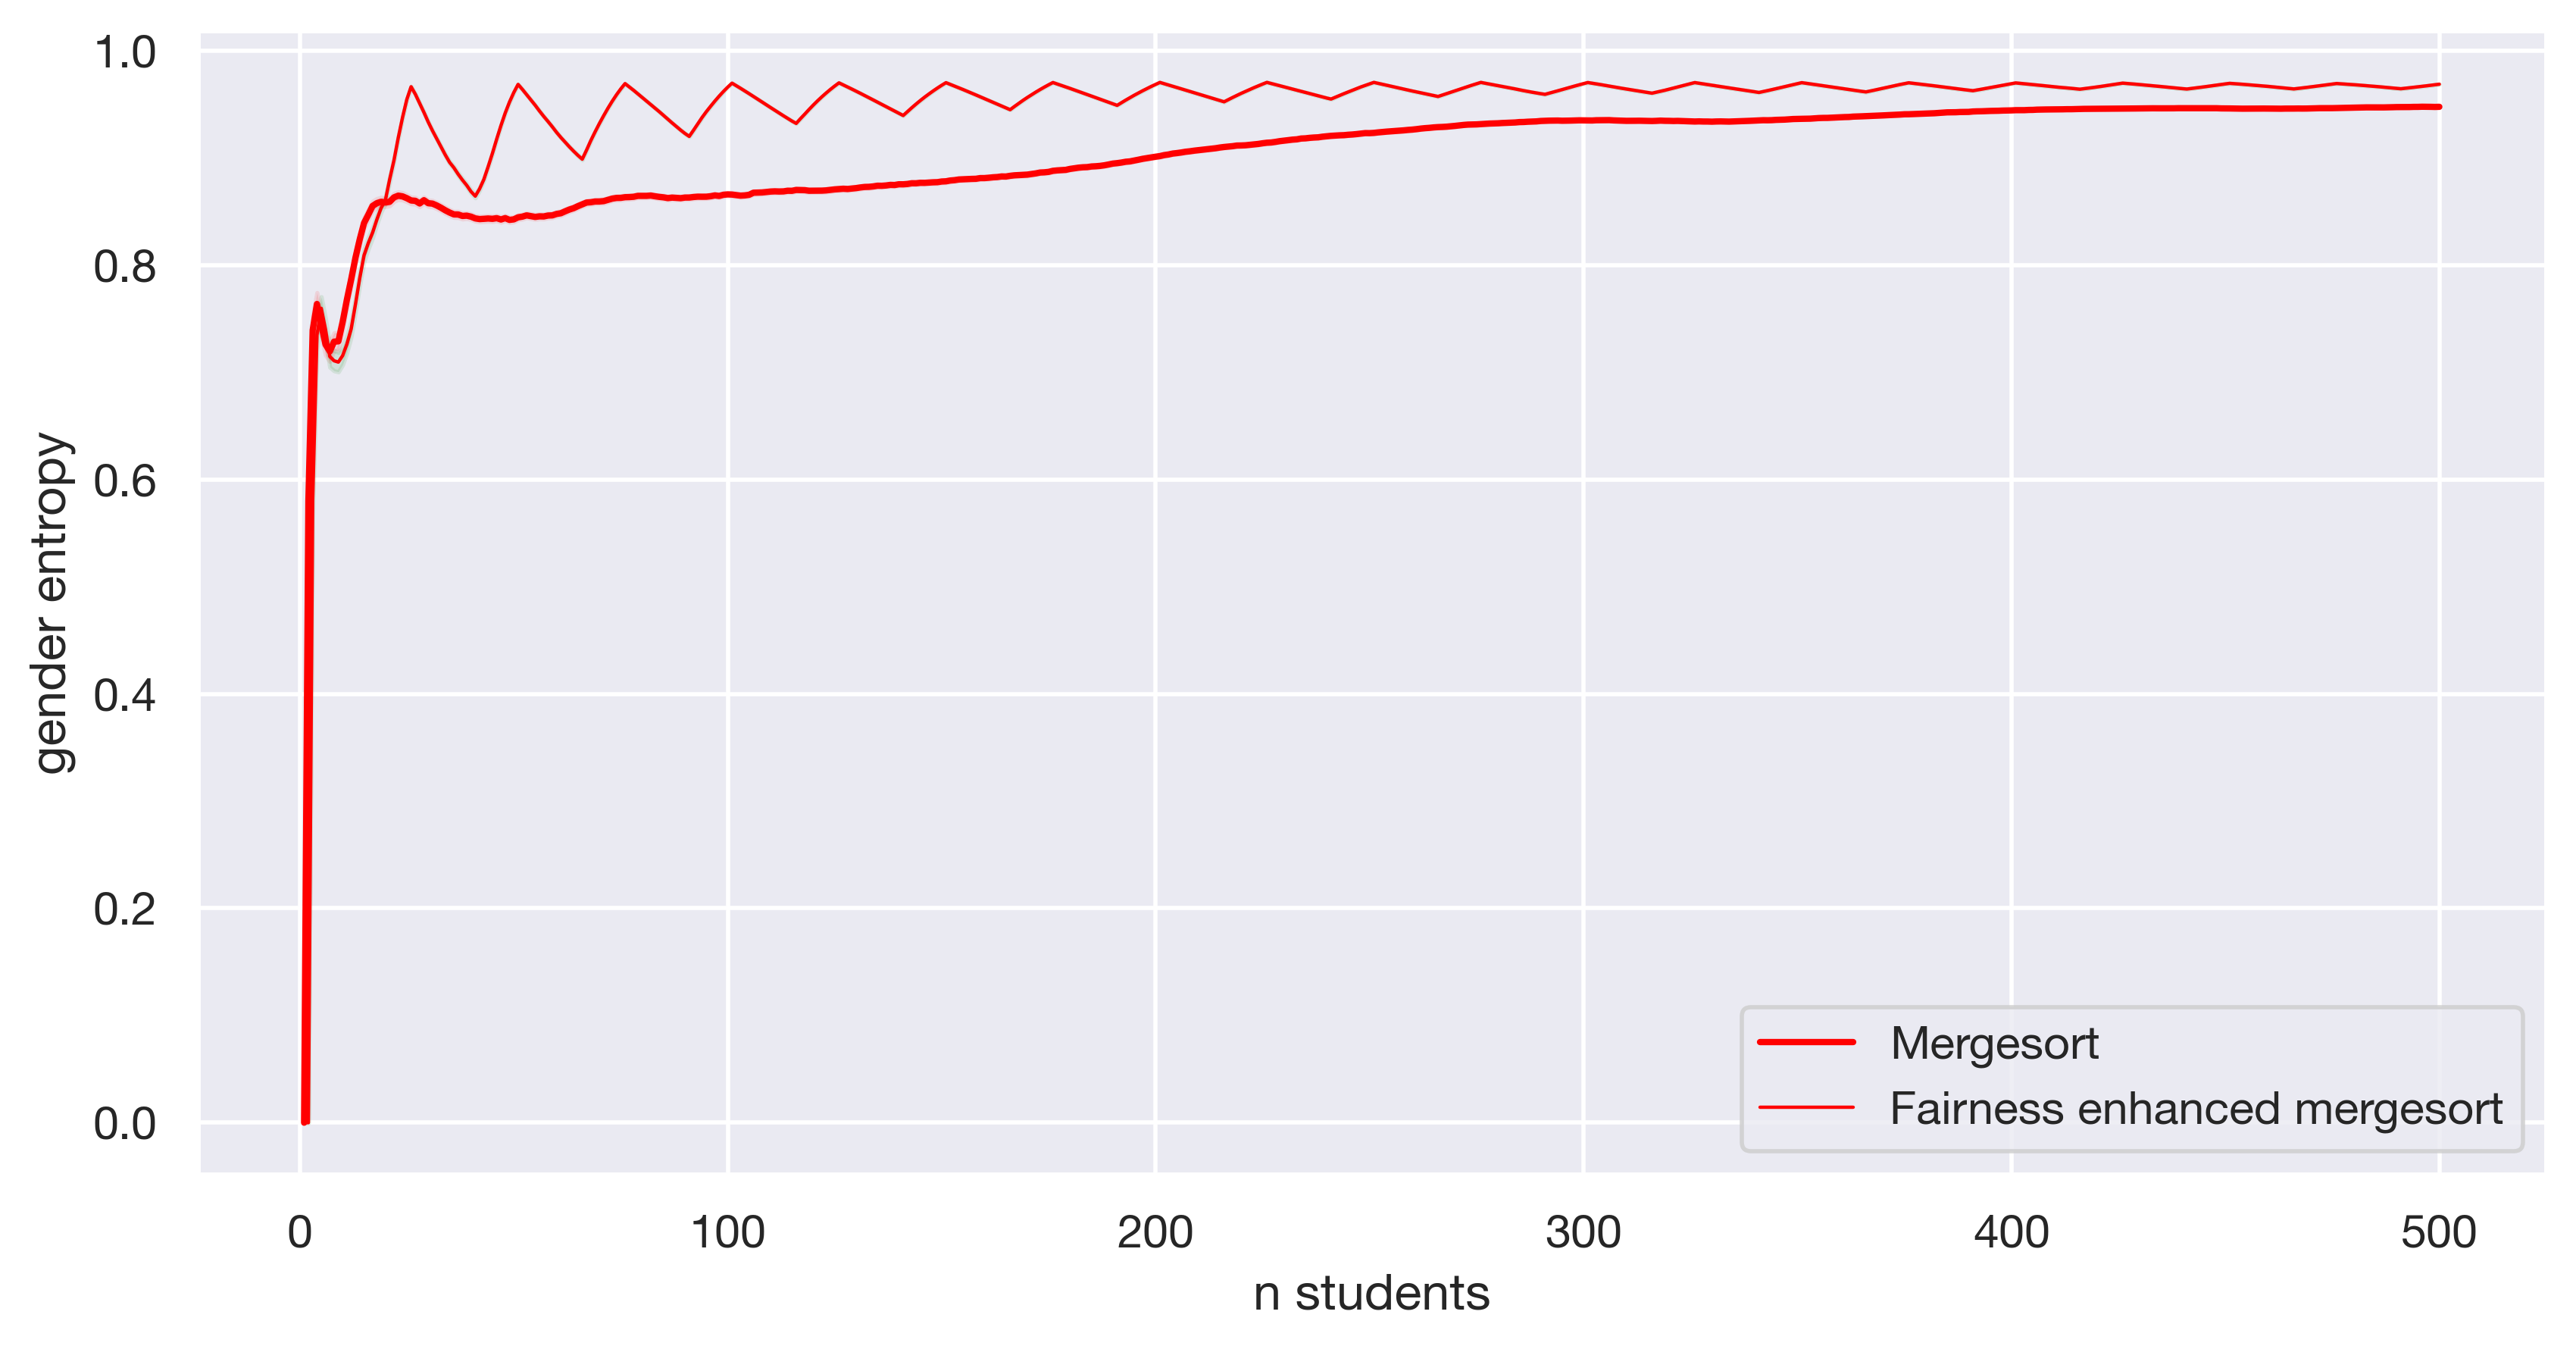

In [25]:
#create entropy mean df and entropy std df
df_merge_fair_ENTROPY = df_merge_fair
df_merge_fair_ENTROPY_std = df_merge_fair_ENTROPY.groupby('Unnamed: 0').std()/np.sqrt(200)
df_merge_fair_ENTROPY_mean =  df_merge_fair_ENTROPY.groupby('Unnamed: 0').mean()


#expand means of df_wo_ENTROPY_mean and df_wo_ENTROPY_std
df_merge_fair_ENTROPY_mean["CMA_gender_entropy"] = df_merge_fair_ENTROPY_mean.entropy_col_GENDER.expanding().mean()

#df_fair_ENTROPY_std["CMA_gender_entropy"] = df_fair_ENTROPY_std.entropy_col_GENDER.expanding().mean()

df_merge_fair_ENTROPY_mean["n_students"] = range(1,len(df_merge_fair_ENTROPY_mean)+1)


#create std error to plot
df_merge_fair_ENTROPY_mean["incr_half_std"] = .5*df_merge_fair_ENTROPY_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_merge_fair_ENTROPY_mean["lower_std"] = df_merge_fair_ENTROPY_mean["entropy_col_GENDER"] - df_merge_fair_ENTROPY_mean["incr_half_std"]
df_merge_fair_ENTROPY_mean["upper_std"] = df_merge_fair_ENTROPY_mean["entropy_col_GENDER"] + df_merge_fair_ENTROPY_mean["incr_half_std"]


# SE for cum: 
#df_fair_ENTROPY_std["CMA_gender_entropy"] = df_fair_ENTROPY_std.entropy_col_GENDER.expanding().mean()

#create std error to plot
#df_merge_fair_ENTROPY_mean["incr_half_std"] = .5*df_merge_fair_ENTROPY_std["CMA_gender_entropy"] #0.5 of std to plot on both sides of mean
#df_merge_fair_ENTROPY_mean["lower_std_cum"] = df_merge_fair_ENTROPY_mean["CMA_gender_entropy"] - df_merge_fair_ENTROPY_mean["incr_half_std"]
#df_merge_fair_ENTROPY_mean["upper_std_cum"] = df_merge_fair_ENTROPY_mean["CMA_gender_entropy"] + df_merge_fair_ENTROPY_mean["incr_half_std"]


#df_merge_fair_mean = df_merge_fair_ENTROPY_mean.copy()

## MEAN Entropy
#entr_fair = df_fair_ENTROPY_mean["entropy_col_GENDER"][499]
#print("entr_fair: ", entr_fair)

sns.lineplot(data=df_sort_BIG_mean[0:500], x="n_students", y="entropy_col_GENDER",  color="red", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG_mean[0:500], alpha=0.1, color="red")

sns.lineplot(data=df_merge_fair_ENTROPY_mean[:500], x="n_students", y="entropy_col_GENDER",  color="red", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_merge_fair_ENTROPY_mean[:500], alpha=0.1, color="green")
plt.xlabel('n students')
plt.ylabel('gender entropy')

plt.legend(["Mergesort", "Fairness enhanced mergesort"], loc ="lower right")


plt.show()

In [ ]:
k=0
l=500


sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="green")

sns.lineplot(data=df_merge_fair_ENTROPY_mean[:500], x="n_students", y="entropy_col_GENDER",  color="turquoise", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_merge_fair_ENTROPY_mean[:500], alpha=0.1, color="turquoise")

plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.legend(["Fairness enhanced XGBoost", "Fairness enhanced mergesort"], loc ="lower right")
plt.show()

# All rankers without random

In [ ]:
k=0
l=500


#Mergesort
sns.lineplot(data=df_sort_BIG_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="red", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG_mean[k:l], alpha=0.1, color="red")

#Gendersort
sns.lineplot(data=gender_df_BIG_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="purple", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=gender_df_BIG_mean[k:l], alpha=0.1, color="purple")

#Rankers
sns.lineplot(data=df_PLAIN_TWO_NY_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="blue", linewidth=0.8) #lw=0.2
plt.fill_between("n_students", "lower_std", "upper_std",data=df_PLAIN_TWO_NY_ENTROPY_mean[k:l], alpha=0.1, color="blue")

sns.lineplot(data=df_wo_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="orange", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_wo_ENTROPY_mean[k:l], alpha=0.1, color="orange")

sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="green")




plt.xlabel('n students')
plt.ylabel('gender entropy')
# plt.title("Averge grade as a function of n student, baselines and XGBoost")
# plt.title('Entropy of models - Gender, all rankers')
plt.legend(['Mergesort Ranker', 'Gendersort Ranker',"Plain XGBoost", "Reduced XGBoost", "Fairness enhanced XGBoost"], loc ="lower right")

# plt.savefig('all_entropy.png')

plt.show()

### All rankers with random

In [ ]:
## Random entropy

# #Random generated dfs
pd.options.mode.chained_assignment = None 

df_use = df_for_random.copy()
df_use = df_use[["Unnamed: 0","COL_GRADE_AVG", "GENDER_bin", "HI_GRADE_AVG"]] #"STRATUM"

for j in range(1,2): #first make one random df that we can append the other random dfs to
    gen_state = random.seed(a=None) #random generator
    df_random1 = shuffle(df_use, random_state=gen_state) #shuffle the df with a random generator based on time
    df_random1["incr_col_mean"] = df_random1.COL_GRADE_AVG.expanding().mean()
    df_random1["n_students"] = range(1,len(df_random1)+1)
    for i in range(1000):
        gen_state = random.seed(a=None)
        df_random2 = shuffle(df_use, random_state=gen_state)
        df_random2["incr_col_mean"] = df_random2.COL_GRADE_AVG.expanding().mean()
        df_random2["n_students"] = range(1,len(df_random2)+1)
        df_random1 = df_random1.append(df_random2)



In [ ]:
# #only take n students from index 1-500
indexs = np.arange(0,500)
df_random_use = df_random1.loc[df_random1['n_students'].isin(indexs)]
df_random_use = df_random_use.reset_index()


In [ ]:
# DENNE VIRKER!!!!

random_value_counts_GENDER = []
i = 0
while i < 999:
    idx = 0
    while idx <= df_random_use.n_students.max():
        random_value_counts_GENDER.append(np.array([df_random_use["GENDER_bin"][:idx].value_counts(normalize=True)]))
        idx = idx+1 
    i = i+1

In [ ]:
df_random_use["value_counts_col_GENDER"] = random_value_counts_GENDER[1:]

In [ ]:
#Entropy for each row

random_entropy_GENDER = []
for i in df_random_use.index:
    random_entropy_GENDER.append(-(df_random_use["value_counts_col_GENDER"][i]*np.log2(df_random_use["value_counts_col_GENDER"][i])).sum())    

In [ ]:
df_random_use["entropy_col_GENDER"] = random_entropy_GENDER

In [ ]:
df_random_use

In [ ]:
# random entropy gender

# list of colors: https://matplotlib.org/stable/gallery/color/named_colors.html

#df_sort["n_students"] = range(len(df_sort))

sns.color_palette("deep")

# randomsort entropy of gender
sns.lineplot(data=df_random_use, x="n_students", y="entropy_col_GENDER", ci="sd", color="cornflowerblue")
plt.show()

In [ ]:
#Mean evt cum


#Mean gender entropy
df_random_mean =  df_random_use.groupby('n_students').mean()
df_random_mean["incr_col_entropy"] = df_random_mean['entropy_col_GENDER'].expanding().mean()


#SMA std entropy
df_random_BIG_std = df_random_use.groupby('n_students').std()/np.sqrt(200)
df_random_BIG_std["incr_col_entropy"] = df_random_use['entropy_col_GENDER'].expanding().mean()


#Adding standard error column for "incr_col_mean" and variables for plotting 200.
df_random_mean["incr_half_std"] = 0.5*df_random_BIG_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_random_mean["lower_std"] = df_random_mean["entropy_col_GENDER"] - df_random_mean["incr_half_std"]
df_random_mean["upper_std"] = df_random_mean["entropy_col_GENDER"] + df_random_mean["incr_half_std"]


#For cum
df_random_mean["incr_half_cum_std"] = 0.5*df_random_BIG_std["incr_col_entropy"] #0.5 of std to plot on both sides of mean
df_random_mean["lower_std_cum"] = df_random_mean["incr_col_entropy"] - df_random_mean["incr_half_cum_std"]
df_random_mean["upper_std_cum"] = df_random_mean["incr_col_entropy"] + df_random_mean["incr_half_cum_std"]



In [ ]:
df_random_mean.reset_index()
df_random_mean.index.names = ['INDEXES']

In [ ]:
df_random_mean["n_students"] = range(1,len(df_random_mean)+1)
df_random_mean

In [ ]:
sns.lineplot(data=df_random_mean, x="n_students", y="incr_col_entropy",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_random_mean, alpha=0.1, color="green")



plt.show()

In [ ]:
sns.lineplot(data=df_random_mean, x="n_students", y="entropy_col_GENDER",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_random_mean, alpha=0.1, color="green")

#sns.lineplot(data=df_random_mean, x="n_students", y="incr_col_entropy",  color="lightgreen", ci="sd")
#plt.fill_between("n_students", "lower_std_cum", "upper_std_cum",data= df_random_mean, alpha=0.1, color="green")


plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.legend(["Random ranker", "CMA Random ranker"], loc ="lower right")
plt.show()

# All rankers entropy

In [ ]:
k=0
l=500


#Mergesort
sns.lineplot(data=df_sort_BIG_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="red", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG_mean[k:l], alpha=0.1, color="red")

#Gendersort
sns.lineplot(data=gender_df_BIG_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="purple", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=gender_df_BIG_mean[k:l], alpha=0.1, color="purple")

#Rankers
sns.lineplot(data=df_PLAIN_TWO_NY_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="blue", linewidth=0.8) #lw=0.2
plt.fill_between("n_students", "lower_std", "upper_std",data=df_PLAIN_TWO_NY_ENTROPY_mean[k:l], alpha=0.1, color="blue")

sns.lineplot(data=df_wo_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="orange", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_wo_ENTROPY_mean[k:l], alpha=0.1, color="orange")

sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="green")

#from "all rankers with random" - run below"
sns.lineplot(data=df_random_mean, x="n_students", y="entropy_col_GENDER",  color="cornflowerblue", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_random_mean, alpha=0.1, color="blue")



plt.xlabel('n students')
plt.ylabel('gender entropy')
# plt.title("Averge grade as a function of n student, baselines and XGBoost")
# plt.title('Entropy of models - Gender, all rankers')
plt.legend(['Mergesort Ranker', 'Gendersort Ranker',"Plain XGBoost", "Reduced XGBoost", "Fairness enhanced XGBoost", "Random Ranker"], loc ="lower right")

# plt.savefig('all_entropy.png')

plt.show()

## FAIR and random/GT

In [ ]:
k=0
l=500


sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="lightgreen", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="lightgreen")

sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="CMA_gender_entropy",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std_cum", "upper_std_cum",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="green")


sns.lineplot(data=df_random_mean, x="n_students", y="entropy_col_GENDER",  color="cornflowerblue", ci="sd", linewidth=0.5)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_random_mean, alpha=0.1, color="cornflowerblue")


plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.legend(["Fairness enhanced XGBoost", "CMA Fairness enhanced XGBoost", "Random ranker"], loc ="lower right")
plt.show()

In [ ]:
GT_df = pd.read_csv("GT.csv")

GUDF_df = pd.read_csv("GUDF.csv") 

GT_df = GT_df.merge(GUDF_df[["GENDER_bin", "Unnamed: 0"]], on="Unnamed: 0", how='left')

# Reset index of GT 
GT_df = GT_df.reset_index()
#For each row incremented, get ratio of M and F
data_value_counts_gen = []
for i in range(1,len(GT_df)+1):
    data_value_counts_gen.append(np.array([GT_df["GENDER_bin"][:i].value_counts(normalize=True)]))
#Create new column with the ratios
GT_df["value_counts_col_GENDER"] = data_value_counts_gen
#For each row incremented, get entropy 
data_entropy = []
for i in range(len(GT_df)):
    data_entropy.append(-(GT_df["value_counts_col_GENDER"][i]*np.log2(GT_df["value_counts_col_GENDER"][i])).sum())
#Create new column with the entropy
GT_df["entropy_col_GENDER"] = data_entropy

GT_df

print("Gender entropy for whole GT:", GT_df.entropy_col_GENDER[-1:].values)




In [ ]:
#UTILITY GROUND TRUTH
print("utility gt: ", GT_df.y_test.mean())

In [ ]:
k=0
l=500


sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="green")

sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="CMA_gender_entropy",  color="lightgreen", ci="sd")
plt.fill_between("n_students", "lower_std_cum", "upper_std_cum",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="lightgreen")


sns.lineplot(data=df_random_mean, x="n_students", y="entropy_col_GENDER",  color="cornflowerblue", ci="sd", linewidth=0.5)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_random_mean, alpha=0.1, color="cornflowerblue")


GT_df['n_students'] = range(1,len(GT_df)+1)
sns.lineplot(data=GT_df[:500], x="n_students", y="entropy_col_GENDER",  color="black", ci="sd", linewidth=0.5, alpha=0.5)


plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.legend(["Fairness enhanced XGBoost", "CMA Fairness enhanced XGBoost", "Random ranker"], loc ="lower right")
plt.show()
